In [2]:
import numpy as np
import skimage
import matplotlib.pyplot as plt
from scipy import interpolate

/home/aramesh/anaconda3/envs/comp-photo/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Q1.1 b) Python initials

img = skimage.io.imread('data/campus.tiff')
print("Shape : {} , number of bits : {}".format(img.shape, img.dtype))
img = img.astype('double')
print("New image dtype : ", img.dtype)

Shape : (4016, 6016) , number of bits : uint16
New image dtype :  float64


In [4]:
# Q1.1 c) Linearization
black = 150
white = 4095

img = (img - black) / (white - black)
img = np.clip(img, 0, 1)

shortlisting bayer patterns : 
 [[0.02762991 0.09429658 0.03320659]
 [0.09277567 0.03751584 0.08263625]
 [0.02636248 0.0851711  0.02991128]]


Text(0.5, 1.0, 'grbg')

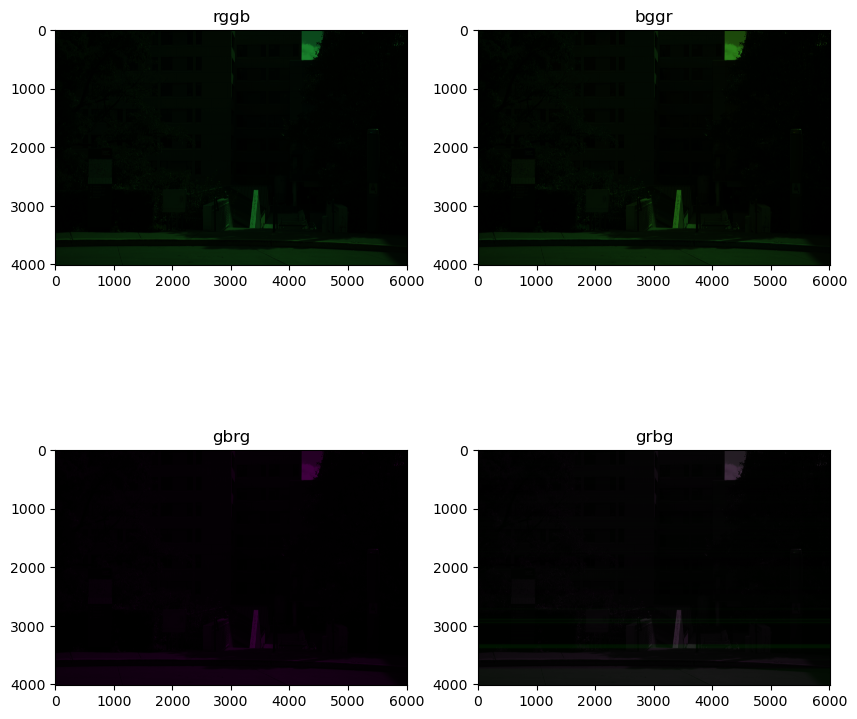

In [5]:
# Q1.1 d) Identifying the right Bayer Pattern
x = 256
print("shortlisting bayer patterns : \n" , img[x:x+3,x:x+3])
# If we sample many x's we can see that this is either rggb or bggr based on the idea 
# that g values for pixels next to each other will likely be the same.
# Looking at this box, we can tell that (0,1), (1,0), (1,2), and (2,1) are all the same color values.
# We can say so for all the corner pixels as well. The center pixel is different.
img_shape = list(img.shape)
img_shape.append(3)
rggb, bggr, grbg, gbrg = np.zeros(img_shape), np.zeros(img_shape), np.zeros(img_shape), np.zeros(img_shape)

for i in range(0,len(img),2) : 
    for j in range(0, len(img[0]), 2) : 
        
        # Assign Green
        rggb[i,j+1,1] = img[i,j+1]
        rggb[i+1,j,1] = img[i+1,j]
        
        bggr[i,j+1,1] = img[i,j+1]
        bggr[i+1,j,1] = img[i+1,j]
        
        grbg[i,j,1] = img[i,i]
        grbg[i+1,j+1,1] = img[i+1,j+1]
        
        grbg[i,j,1] = img[i,i]
        grbg[i+1,j+1,1] = img[i+1,j+1]
    
        # Assign Red
        rggb[i,j,0] = img[i,j]
        bggr[i+1,j+1,0] = img[i+1,j+1]
        grbg[i,j+1,0] = img[i,j+1]
        gbrg[i+1,j,0] = img[i+1,j]
        
        # Assign Blue
        rggb[i+1,j+1,2] = img[i+1,j+1]
        bggr[i,j,2] = img[i,j]
        grbg[i+1,j,2] = img[i+1,j]
        gbrg[i,j+1,2] = img[i,j+1]
        
# rggb can also be produced as shown below
# r = img[::2, ::2]
# b = img[1::2, 1::2]
# g1 = img[::2, 1::2]
# g2 = img[1::2, ::2]
# We would however have to overlay g1 and g2 hence produced. 
# This can be done by simply summing them.
        
# Combining the images
fig, axs = plt.subplots(2,2, figsize=(10,10))
axs[0,0].imshow(rggb)
axs[0,0].set_title('rggb')
axs[0,1].imshow(bggr)
axs[0,1].set_title('bggr')
axs[1,0].imshow(gbrg)
axs[1,0].set_title('gbrg')
axs[1,1].imshow(grbg)
axs[1,1].set_title('grbg')
# We can print channel-wise too but visually this doesn't give us enough to decide with certainity. 
# Will confirm after white-balancing.
# !! After white balancing : rggb seems to be the best fit bayer pattern as it best visually preserves features as we'd expect.
# This can be seen in the images we generate upon running the white-balancing cell below.

rggb seems to be the best fit bayer pattern as it best visually preserves features as we'd expect.


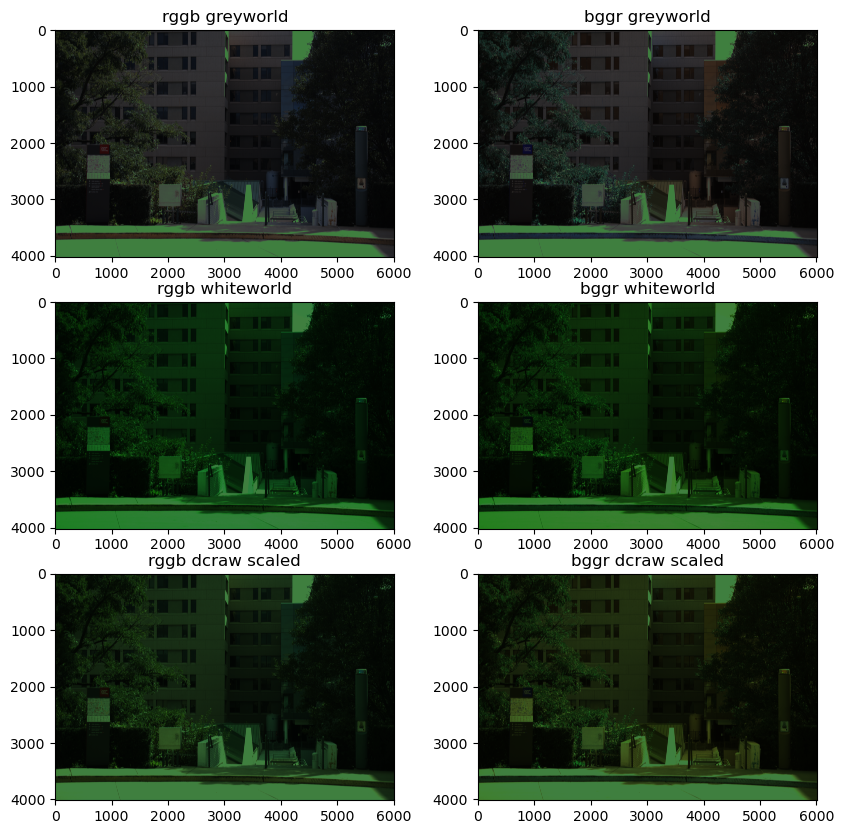

In [6]:
# Q1.1 e) White Balancing

# We'll try white balancing on both the above possible bayer pattern resolved images.

# Is this correct? Cant't this have many saturated items? Divide step in decimal could cause this if den is smaller than num.
def grey_world(img) : 
    
    r_avg = img[:,:,0].mean()
    g_avg = img[:,:,1].mean()
    b_avg = img[:,:,2].mean()
    
    r_norm = img[:,:,0]  * g_avg / r_avg
    g_norm = img[:,:,1]  * g_avg / g_avg
    b_norm = img[:,:,2]  * g_avg / b_avg
    
    img_norm = np.dstack((r_norm, g_norm, b_norm))
    
    return img_norm

def white_world(img) :
    
    r_max = img[:,:,0].max()
    g_max = img[:,:,1].max()
    b_max = img[:,:,2].max()
    
    r_norm = img[:,:,0] * (g_max)/ r_max
    g_norm = img[:,:,1] * (g_max)/ g_max
    b_norm = img[:,:,2] * (g_max)/ b_max
    
    img_norm = np.dstack((r_norm, g_norm, b_norm))
    
    return img_norm

def dcraw_scale(img) :
    
    img[:,:,0] *= 2.394531
    img[:,:,2] *= 1.597656
    
    return img
    
fig, axs = plt.subplots(3,2, figsize=(10,10))
rggb_greyworld = grey_world(rggb)
bggr_greyworld = grey_world(bggr)
rggb_whiteworld = white_world(rggb)
bggr_whiteworld = white_world(bggr)
rggb_dcraw_scaled = dcraw_scale(rggb)
bggr_dcraw_scaled = dcraw_scale(bggr)

axs[0,0].imshow(np.clip(rggb_greyworld*5, 0, 1))
axs[0,0].set_title('rggb greyworld')
axs[0,1].imshow(np.clip(bggr_greyworld*5, 0, 1))
axs[0,1].set_title('bggr greyworld')
axs[1,0].imshow(np.clip(rggb_whiteworld*5, 0, 1))
axs[1,0].set_title('rggb whiteworld')
axs[1,1].imshow(np.clip(bggr_whiteworld*5, 0, 1))
axs[1,1].set_title('bggr whiteworld')
axs[2,0].imshow(np.clip(rggb_dcraw_scaled*5, 0, 1))
axs[2,0].set_title('rggb dcraw scaled')
axs[2,1].imshow(np.clip(bggr_dcraw_scaled*5, 0, 1))
axs[2,1].set_title('bggr dcraw scaled')


print("rggb seems to be the best fit bayer pattern as it best visually preserves features as we'd expect.")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


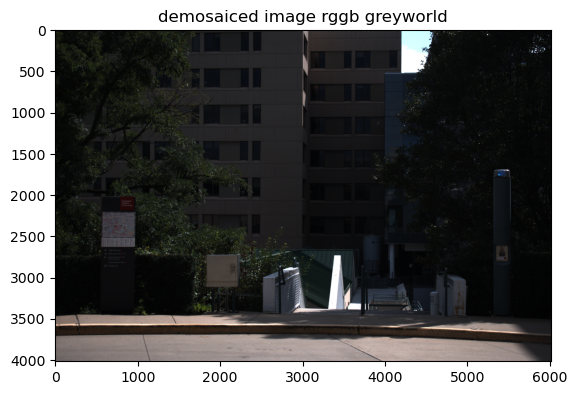

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


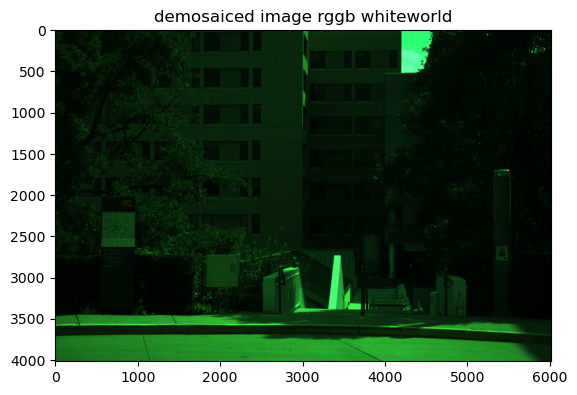

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


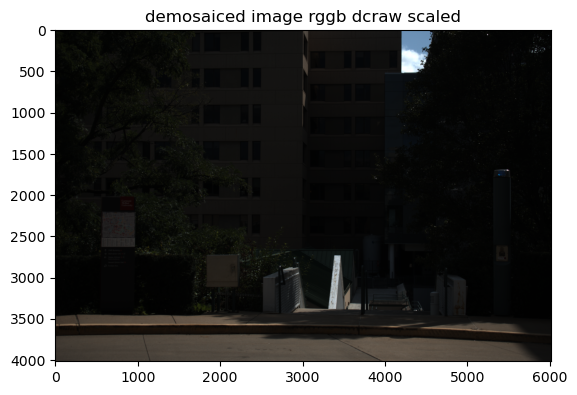

In [20]:
# Q1.1 f) Demosaicing
def demosaicing(img, plot_title='', mode=0, should_plot=True) : 
    img_sum = img[:,:,0] + img[:,:,1] + img[:,:,2] # doesn't need to be done
    r_x, r_y = np.arange(0,img_sum.shape[0],2), np.arange(0,img_sum.shape[1],2)
    g_x, g_y = np.arange(0,img_sum.shape[0],2), np.arange(1,img_sum.shape[1],2)
    g_x2, g_y2 = np.arange(1,img_sum.shape[0],2), np.arange(0,img_sum.shape[1],2)
    b_x, b_y = np.arange(1,img_sum.shape[0],2), np.arange(1,img_sum.shape[1],2)

    r_xx, r_yy = np.meshgrid(r_y, r_x)
    g_xx, g_yy = np.meshgrid(g_y, g_x)
    g_xx2, g_yy2 = np.meshgrid(g_y2, g_x2)
    b_xx, b_yy = np.meshgrid(b_y, b_x)

    r_z = img_sum[r_yy, r_xx]
    g_z = img_sum[g_yy, g_xx]
    g_z2 = img_sum[g_yy2, g_xx2]
    b_z = img_sum[b_yy, b_xx]

    f_r = interpolate.interp2d(r_y, r_x, r_z)
    f_g = interpolate.interp2d(g_y, g_x, g_z)
    f_g2 = interpolate.interp2d(g_y2, g_x2, g_z2)
    f_b = interpolate.interp2d(b_y, b_x, b_z)

    y, x = np.arange(img_sum.shape[0]), np.arange(img_sum.shape[1])
    img_demosaiced = np.zeros(img_shape)

    img_demosaiced[:,:,0] = f_r(x,y)
    img_demosaiced[:,:,1] = (f_g(x,y) + f_g2(x,y)) if mode==0 else (f_g(x,y) + f_g2(x,y))/2
    img_demosaiced[:,:,2] = f_b(x,y)
    
    if should_plot :
        plt.imshow(img_demosaiced)
        plt.title(plot_title)
        plt.show()
    
    return img_demosaiced

_ = demosaicing(rggb_greyworld, 'demosaiced image rggb greyworld')
_ = demosaicing(rggb_whiteworld, 'demosaiced image rggb whiteworld')
img_demosaiced = demosaicing(rggb_dcraw_scaled,'demosaiced image rggb dcraw scaled',1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


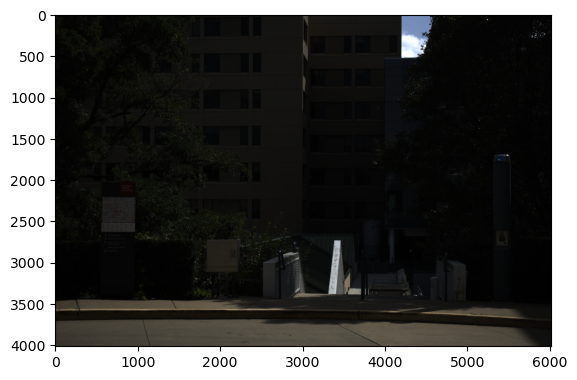

In [21]:
# Q1.1 g) Color-Correction Step
# From dcraw file
# 1x9 : { 6988,-1384,-714,-5631,13410,2447,-1485,2204,7318 }
def color_correction(img_demosaiced, should_plot=True) : 
    M_xyz2cam = np.array([[6988,-1384,-714],[-5631,13410,2447],[-1485,2204,7318]]) / 10000.0
    M_srgb2xyz = np.array([[0.4124564 ,0.3575761 ,0.1804375],[0.2126729, 0.7151522, 0.0721750],[0.0193339, 0.1191920, 0.9503041]])

    M_srgb2cam = M_xyz2cam * M_srgb2xyz
    M_srgb2cam[0,:] = (M_srgb2cam[0,:] / sum(M_srgb2cam[0,:]))
    M_srgb2cam[1,:] = (M_srgb2cam[1,:] / sum(M_srgb2cam[1,:]))
    M_srgb2cam[2,:] = (M_srgb2cam[2,:] / sum(M_srgb2cam[2,:]))

    M_cam2srgb = np.linalg.pinv(M_srgb2cam)
    M_cam2srgb[0,:] = (M_cam2srgb[0,:] / sum(M_cam2srgb[0,:]))
    M_cam2srgb[1,:] = (M_cam2srgb[1,:] / sum(M_cam2srgb[1,:]))
    M_cam2srgb[2,:] = (M_cam2srgb[2,:] / sum(M_cam2srgb[2,:]))

    img_demosaiced_temp1 = img_demosaiced.transpose(2,0,1)
    img_demosaiced_temp2 = img_demosaiced_temp1.reshape(3,-1)
    img_cc_temp1 = np.matmul(M_cam2srgb,img_demosaiced_temp2)
    img_cc_temp2 = img_cc_temp1.reshape(3,img_demosaiced_temp1.shape[1], img_demosaiced_temp1.shape[2]) 
    img_cc = img_cc_temp2.transpose(1,2,0)

    if should_plot :
        plt.imshow(img_cc)
    
    return img_cc

img_cc = color_correction(img_demosaiced)

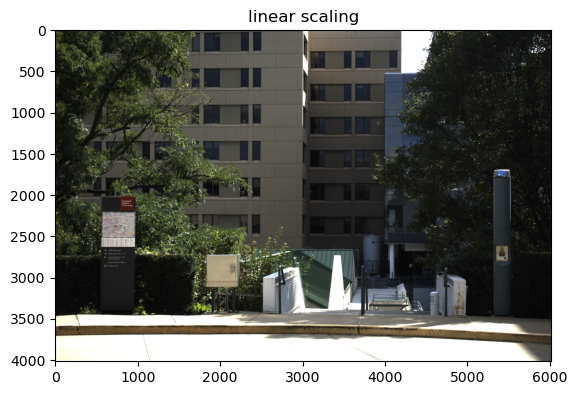

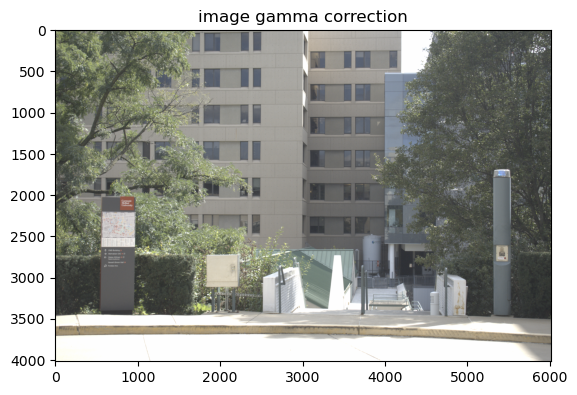

In [22]:
# Q1.1 h) Brightness Adjustment and Gamma Correction
# Linear scaling
# Let the new brightness by 1.25xed
def linear_scaling(img_cc, scale, should_plot=True):
    img_scaled_gray = np.clip(skimage.color.rgb2gray(img_cc) * scale, 0, 1)
    img_scaled = np.clip(img_cc * scale, 0, 1)
    if should_plot : 
        plt.imshow(img_scaled)
        plt.title('linear scaling')
        plt.show()
    return img_scaled

# Gamma Correction
def gamma_correction(val) : 
    if val <= 0.0031308 : 
        return 12.92 * val
    else : 
        return (1+0.055) * np.power(val, 1/2.4) - 0.055

img_scaled = linear_scaling(img_cc, scale=5)
gc_f = np.vectorize(gamma_correction)
image_gc = gc_f(img_scaled)
plt.imshow(image_gc)
plt.title('image gamma correction')
plt.show()

In [ ]:
# Q1.1 i) Compression
image_final = (image_gc * 255).astype('uint8')
skimage.io.imsave('image_gc_ls1p25.png', image_final)
skimage.io.imsave('image_gc_ls1p25.jpeg', image_final, quality=95) 
# QUALITY RELATED EXPERIMENTS FOR REPORT PENDING !!!!

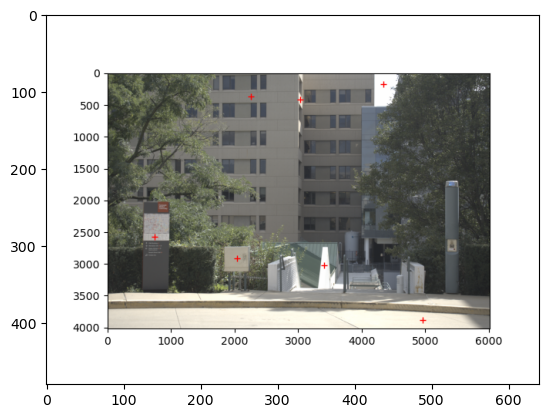

In [23]:
# Q1.2) Manual white balancing

# Uncomment the below to select points
# %matplotlib qt
# # Selecting a list of points,
# plt.imshow(image_gc)
# gin = plt.ginput(n=8)
# plt.show()

# Points selected
%matplotlib inline
selected_pts_gin = plt.imread('ginput_selections.png')
plt.imshow(selected_pts_gin)
plt.show()

# Points previously selected
gin = [(3407.7580645161297, 3021.4870967741936), # whitest point at center towards the bottom
 (739.3709677419356, 2572.7129032258067), # on the map on the left (white-brown)
 (2037.1774193548388, 2912.325806451613), # on the electronics box (white-brown)
 (2255.5, 365.22903225806476), # Building flat plane towards camera (white-brown)
 (3031.758064516129, 413.74516129032236), # Building sideways plane (brightness) (white-ish)
 (4341.693548387097, 171.16451612903256), # sky background (white)
 (4960.274193548387, 3882.648387096774)] # floor at bottom (white-ish)

# Note : 
# first coordinate is column, second is row

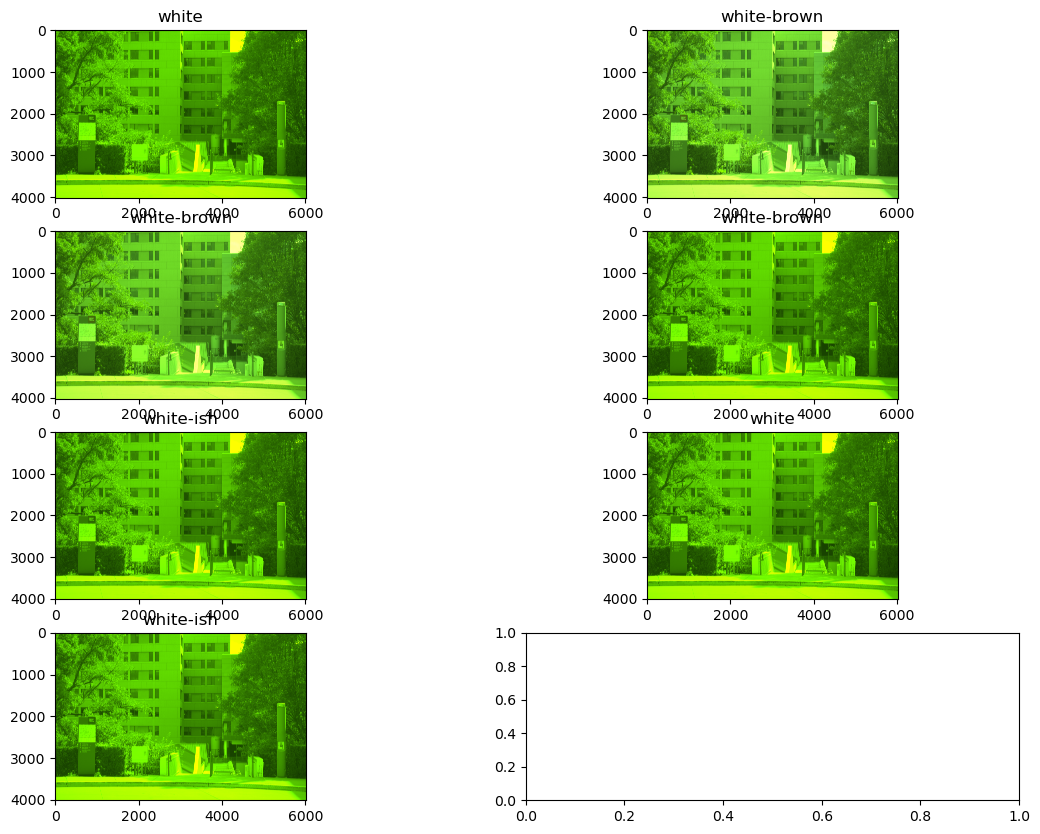

In [42]:
# Normalizing based on a point, and propagating these scales.
fig, axs = plt.subplots(4,2, figsize=(14,10))
names = ['white', 'white-brown', 'white-brown', 'white-brown', 'white-ish', 'white', 'white-ish']
for i, pts in enumerate(gin) : 
    pts = list(pts)
    pts = [int(pt) for pt in pts]
    # Making all three values equal to the green channel
    im = rggb.copy()
    selected_pts = im[pts[1], pts[0]]

    if selected_pts[0] == selected_pts[1] == selected_pts[2] : 
        pass
    else : 
        selected_pts_red_scale = selected_pts[1] / (selected_pts[0]+1)
        selected_pts_blue_scale = selected_pts[1] / (selected_pts[2]+1)

        im[:,:,0] *= selected_pts_red_scale
        im[:,:,2] *= selected_pts_red_scale

    im = demosaicing(im, should_plot=False)
    im = color_correction(im, should_plot=False)
    im = linear_scaling(im, scale=5, should_plot=False)
    im = gc_f(im)

    axs[i//2][i%2].imshow(im)
    axs[i//2][i%2].set_title(names[i])

AttributeError: 'numpy.ndarray' object has no attribute 'equal'